# Allowables

---



In [1]:
import grama as gr
from plotnine import *
from grama.models import make_cantilever_beam
from grama.models import make_plate_buckle

DF = gr.Intention()

md_beam = make_cantilever_beam()
md_beam.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      t: [2, 4]
      w: [2, 4]
    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}
    copula:
        Independence copula
  functions:
    cross-sectional area: ['w', 't'] -> ['c_area']
    limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
    limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']


## Compare Allowables to Monte Carlo


In [2]:
## Common probability value
alpha = 0.01

## Allowable computation
df_allowables = (
    md_beam
    ## Single "conservative" evaluation
    >> gr.ev_conservative(
        df_det="nom",
        quantiles=alpha,
    )
    >> gr.tf_mutate(source="allowable")
)

## Monte Carlo computation
df_mc = (
    md_beam
    ## Many evaluations
    >> gr.ev_monte_carlo(
        n=1e3,
        df_det="nom",
        seed=101,
    )
)
df_quantiles = (
    df_mc
    ## Summary of output values
    >> gr.tf_summarize(
        g_stress=gr.quant(DF.g_stress, p=alpha),
        g_disp=gr.quant(DF.g_disp, p=alpha),
    )
    >> gr.tf_mutate(source="true")
)

df_both = (
    df_allowables 
    >> gr.tf_select("g_disp", "g_stress", "source")
    >> gr.tf_bind_rows(df_quantiles)
)
df_both

eval_monte_carlo() is rounding n...


,g_disp,g_stress,source
0,-0.188263,-0.208134,allowable
1,-0.174174,-0.053179,true


Visualize the results


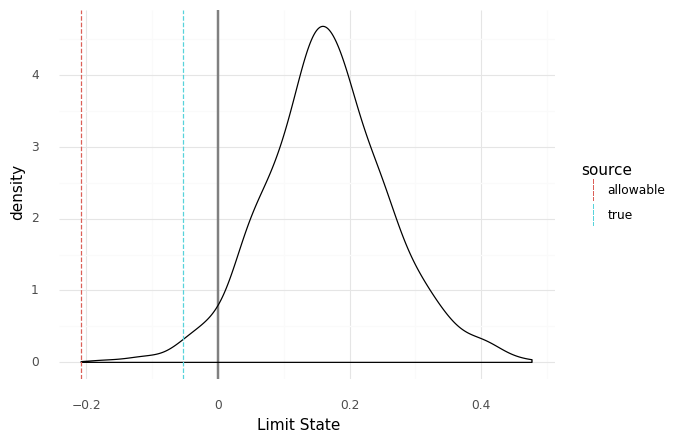

<ggplot: (8788591535545)>

In [3]:
(
    ggplot()
    + geom_vline(
        xintercept=0,
        color="grey",
        size=1,
    )
    + geom_density(
        data=df_mc,
        mapping=aes(x="g_stress")
    )
    + geom_vline(
        data=df_both,
        mapping=aes(xintercept="g_stress", color="source"),
        linetype="dashed",
    )
    
    + theme_minimal()
    + labs(
        x="Limit State",
    )
)

## Why Grama? Trivial to Generalize Analyis to Other Models


In [4]:
md_plate = make_plate_buckle()
md_plate.printpretty()

model: Plate Buckling

  inputs:
    var_det:
      h: [6, 18]
      L: [0.00064, 0.00256]
      t: [0.03, 0.12]
      w: [6, 18]
    var_rand:
      E: (+0) norm, {'loc': 10344.736842105263, 'scale': 258.7392188662194}
      mu: (+0) beta, {'a': 1.0039017654316746, 'b': 0.8622680473775106, 'loc': 0.3094053248270583, 'scale': 0.021594675172941728}
    copula:
        Gaussian copula with correlations:
  var1 var2      corr
0    E   mu  0.371244
  functions:
    limit state: ['t', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']


In [21]:
df_plate_allowables = (
    md_plate
    ## BEGIN Allowables
    >> gr.ev_conservative(df_det="nom", quantiles=alpha)
    ## END Allowables
    >> gr.tf_select("g_buckle")
    >> gr.tf_mutate(source="Allowables")
)
df_plate_mc = (
    md_plate
    >> gr.ev_monte_carlo(
        n=1e4,
        df_det="nom",
        seed=101,
    )
)
df_plate_quant = (
    df_plate_mc
    >> gr.tf_summarize(g_buckle=gr.quant(DF.g_buckle, p=alpha))
    >> gr.tf_mutate(source="True (MC)")
)

df_plate = (
    df_plate_quant
    >> gr.tf_bind_rows(df_plate_allowables)
)
df_plate

eval_monte_carlo() is rounding n...


,g_buckle,source
0,0.108729,True (MC)
1,0.116197,Allowables


Visualize results


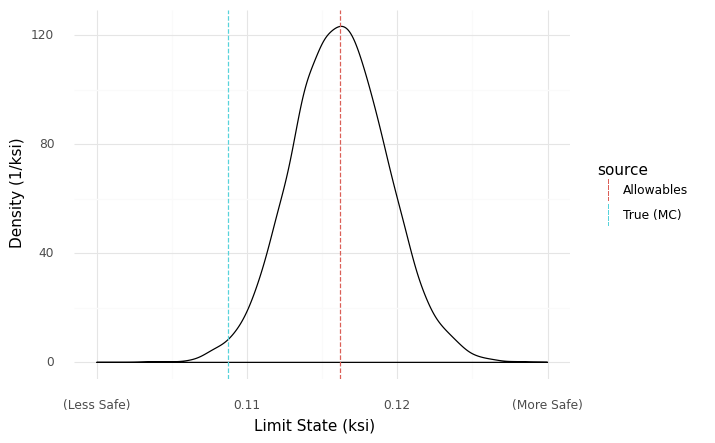

<ggplot: (8788553538429)>

In [23]:
fig_plate = (
    ggplot()
    + geom_density(
        data=df_plate_mc,
        mapping=aes(x="g_buckle")
    )
    + geom_vline(
        data=df_plate,
        mapping=aes(xintercept="g_buckle", color="source"),
        linetype="dashed",
    )
    
    + scale_x_continuous(
        breaks=(0.10, 0.11, 0.12, 0.13),
        labels=("(Less Safe)", "0.11", "0.12", "(More Safe)"),
        limits=(0.10, 0.13),
    )
    + theme_minimal()
    + labs(
        x="Limit State (ksi)",
        y="Density (1/ksi)"
    )
)
fig_plate.save("plate-dist.png")
fig_plate
